Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 3
# Privacy-Preserving Statistical Analysis with Differential Privacy 

<img src="images/histogram.jpg" width=800 />

The goal of this notebook is to demonstrate how to generate and release basic statistical outcomes in a differntially private fashion. We will assess the impact on various privacy levels and dataset sizes on accuracy.

We are using a dataset conataining demographic data about Californian residents from the Public Use Microdata Sample (PUMS) statistics.
The dataset includes more than 1.2m records and is therefore well suited to experiment with different sample sizes.

The data includes personal information like gender, age, ethnical background, income and marital status. For our analysis, we will focus on creating histograms for the yearly income.

The default method for generating a histogram in SmartNoise is by releasing counts of each bin or category using the geometric mechanism. The geometric mechanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations. It is also possible to generate histograms from the more typical Laplace mechanism. We show both approaches below.

## Installs and imports

In [1]:
# %pip install opendp-smartnoise seaborn

In [2]:
import os
import opendp.smartnoise.core as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

datafile = os.path.join('.','data','PUMS-california-demographics.csv')
samplefile = os.path.join('.','data','sample.csv') # export generated sample and import for DP analysis

df = pd.read_csv(datafile, usecols = range(1,11))

## Inspect Dataset

In [3]:
df.head(8)

,state,puma,sex,age,educ,income,latino,black,asian,married
0,6,60100,0,83,9,20500.0,0,0,0,1
1,6,60100,1,81,9,4800.0,0,0,0,1
2,6,60100,0,45,9,12000.0,0,0,0,1
3,6,60100,1,42,12,7200.0,0,0,0,1
4,6,60100,0,35,11,55600.0,0,0,0,1
5,6,60100,1,34,11,4600.0,0,0,0,1
6,6,60100,0,20,8,8000.0,1,0,0,0
7,6,60100,0,35,12,43000.0,0,0,0,0


## Preprocess data
Converting the continuous variable income to catagories as foundation for the further analysis.

In [4]:
# remove entries with negative income values
df.drop (df[df['income'] < 0].index, inplace=True)

income_categories = ['less 10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k', '60k-80k', '80k-100k', '100k-150k', 'above 150k']
cut_bins = [-1, 10000, 20000, 30000, 40000, 50000, 60000, 80000, 100000, 150000, 1000000] # 10 categories
df['inc_cat'] = pd.cut(df['income'], bins=cut_bins, labels=income_categories)

## Review histogram of income from original dataset

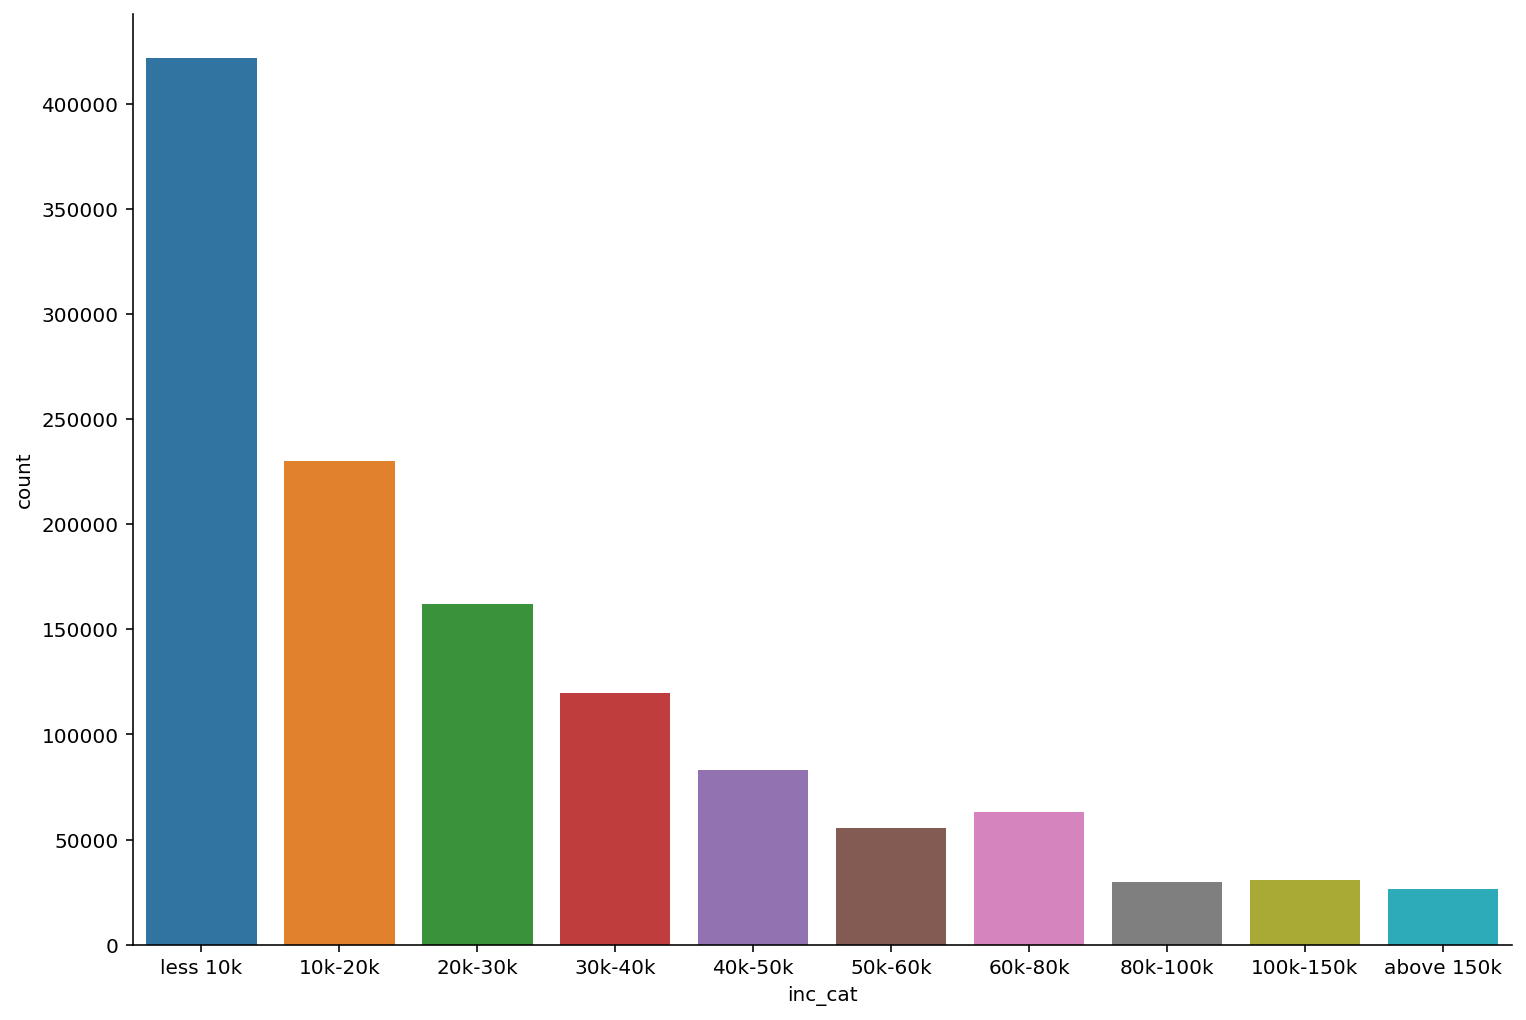

In [5]:
fig = sns.catplot(x="inc_cat", kind="count", data=df, height=7, aspect=1.5)
plt.show()

## Draw a sample for conducting the DP analysis

In [6]:
sample_size = 10000

# draw sample 
sample = df.sample(n = sample_size, random_state=0)
# save sample for DP analysis
sample.to_csv(samplefile, index=False)

We define two functions to support the further analysis:
1. `dp_histo` is used to generate data for the differentially private histograms for a given privacy parameter epsilon. It generates counts based on two alternative mechanisms to generate statistical noise: Geometric and Laplace.
2. `perc_error` is used to calculate the percentage deviation between the true and the differentially private distribution.

In [7]:
def dp_histo(epsilon = 0.5):
    
    var_names = ['state', 'puma', 'sex', 'age', 'educ', 'income', 'latino', 'black', 'asian', 'married', 'inc_cat']

    with sn.Analysis(protect_floating_point=False) as analysis:
        data = sn.Dataset(path = samplefile, column_names = var_names)
        nsize = sample_size    

        income_histogram = sn.dp_histogram(
                data['inc_cat'], 
                categories = income_categories,
                null_value = "-1",
                privacy_usage = {'epsilon': epsilon}
            )

        income_prep = sn.histogram(data['inc_cat'],
                categories = income_categories, null_value = "-1")
        income_histogram2 = sn.laplace_mechanism(income_prep, privacy_usage={"epsilon": epsilon, "delta": .000001})

    analysis.release()
    
    return income_histogram.value, income_histogram2.value

def perc_error(true_col, dp_col):
    return sum(abs(true_col - dp_col)) / sum(true_col) * 100

In [8]:
epsilon = 0.1

geo_counts, laplace_counts = dp_histo(epsilon) 

print("Income histogram Geometric DP release:   " + str(geo_counts))
print("Income histogram Laplace DP release:     " + str(laplace_counts.astype(int)))

# Clarify meaning of 11th value (bins = 10)

Income histogram Geometric DP release:   [3397 1849 1314  972  645  509  512  245  270  211    0]
Income histogram Laplace DP release:     [3411 1865 1380  976  645  550  550  219  299  194  -24]


In [9]:
results = pd.DataFrame(index=income_categories)
private_df = pd.read_csv(samplefile)
results['True'] = private_df['inc_cat'].value_counts()
results['Geom-DP'] = geo_counts[:len(income_categories)]
results['Lapl-DP'] = laplace_counts[:len(income_categories)].astype(int)

results

,True,Geom-DP,Lapl-DP
less 10k,3410,3397,3411
10k-20k,1849,1849,1865
20k-30k,1316,1314,1380
30k-40k,992,972,976
40k-50k,656,645,645
50k-60k,494,509,550
60k-80k,518,512,550
80k-100k,279,245,219
100k-150k,257,270,299
above 150k,229,211,194


In [10]:
error_geom = perc_error(results['True'], results['Geom-DP'])
error_lapl = perc_error(results['True'], results['Lapl-DP'])

print ('Geometric DP mechanism with ε = ' + str(epsilon) + ' : Deviation compared to non-private sample  = ' + str(round(error_geom,1)) +'%')
print ('Laplace DP mechanism with ε = ' + str(epsilon) + ' : Deviation compared to non-private sample = ' + str(round(error_lapl,1)) +'%')

Geometric DP mechanism with ε = 0.1 : Deviation compared to non-private sample  = 1.3%
Laplace DP mechanism with ε = 0.1 : Deviation compared to non-private sample = 3.3%


## Assessing the impact of privacy guarantee and amount of data on accuracy
We will generate histograms for various sample sizes. Each histogram compares the data from the original distribution with differentially private counts at different privacy levels (controlled by the privacy parameter ε). Low values of ε are associated with higher privacy guarantees and therefore higher amounts of statistical noise. The following charts can be used to develop an intuition for the tradeoff between privacy and accuracy.
Furthermore, we will see how the loss in accuracy can be compensated by increasing the sample size. Feel free to adjust `sample_sizes` and `epsilons` in the cell below to investigate different settings.

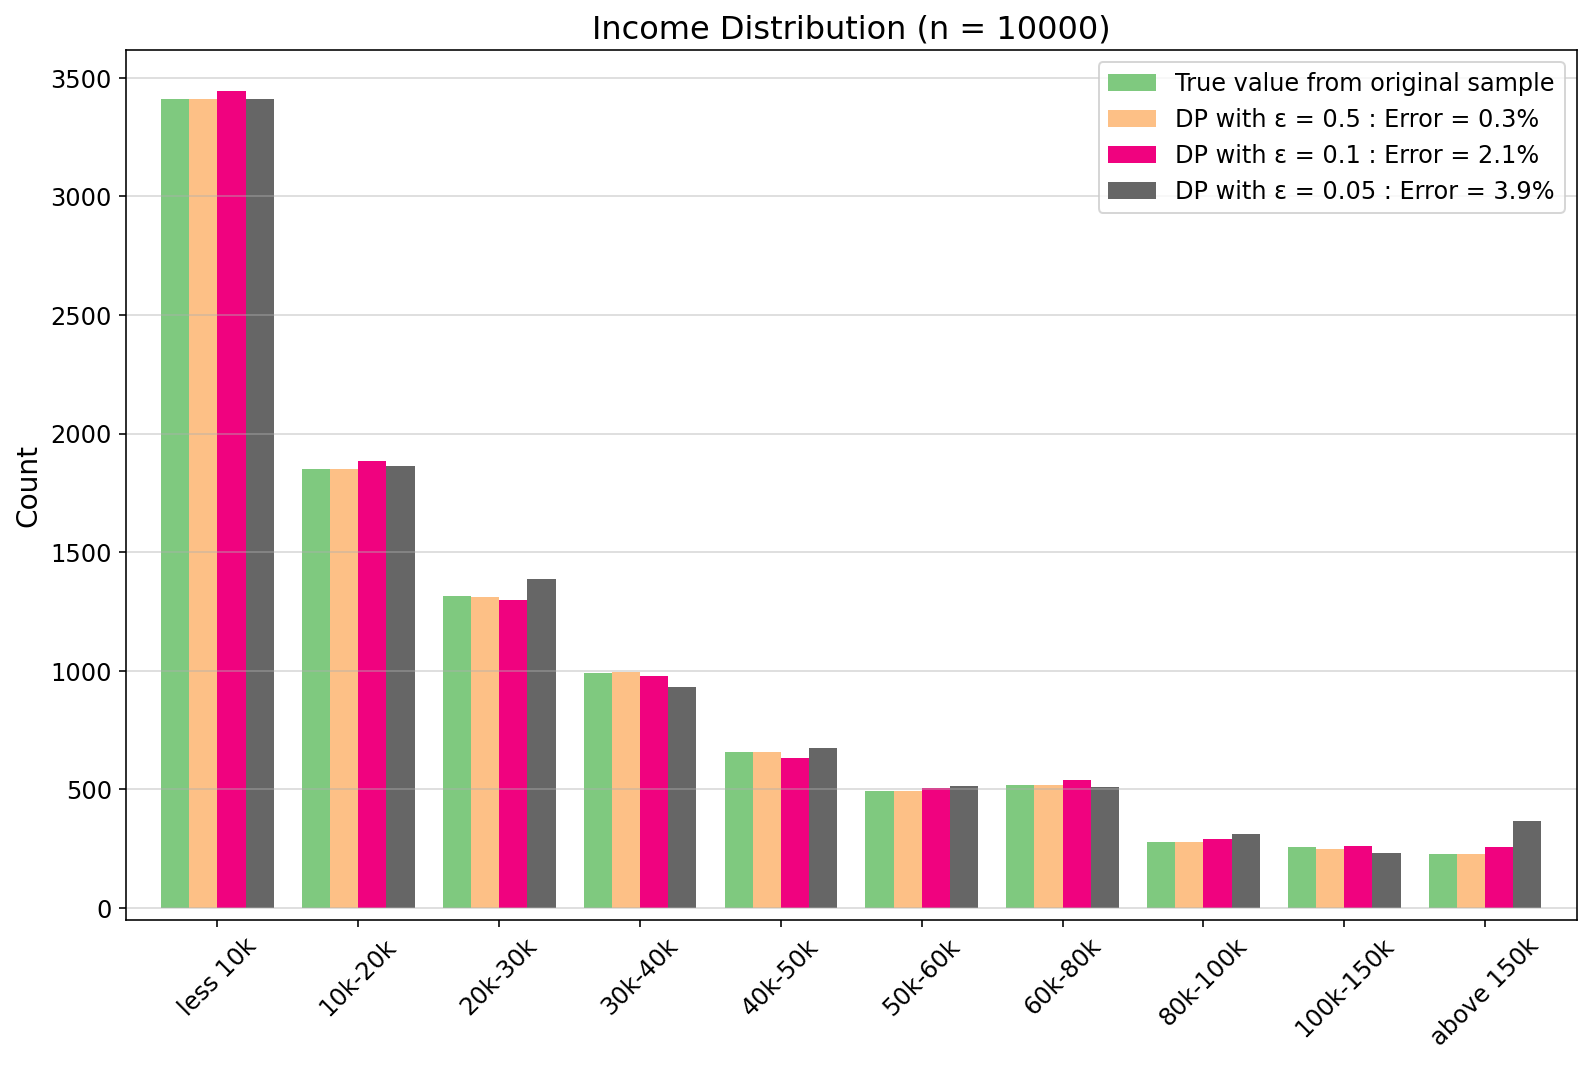

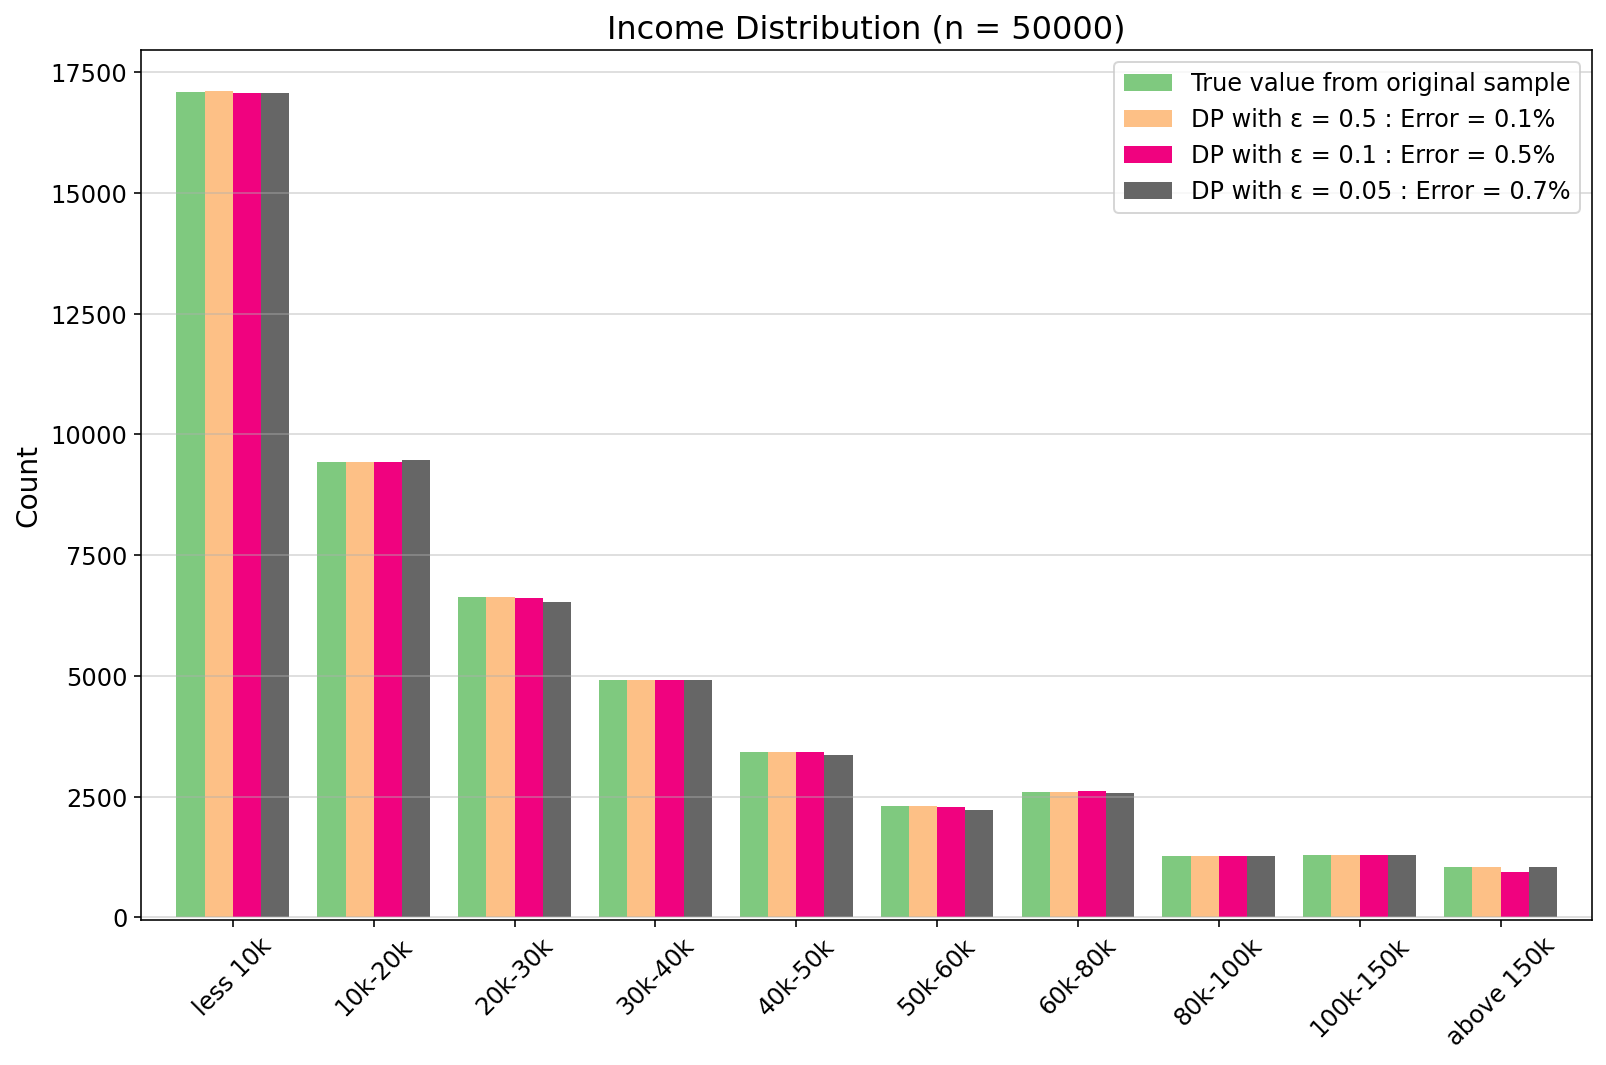

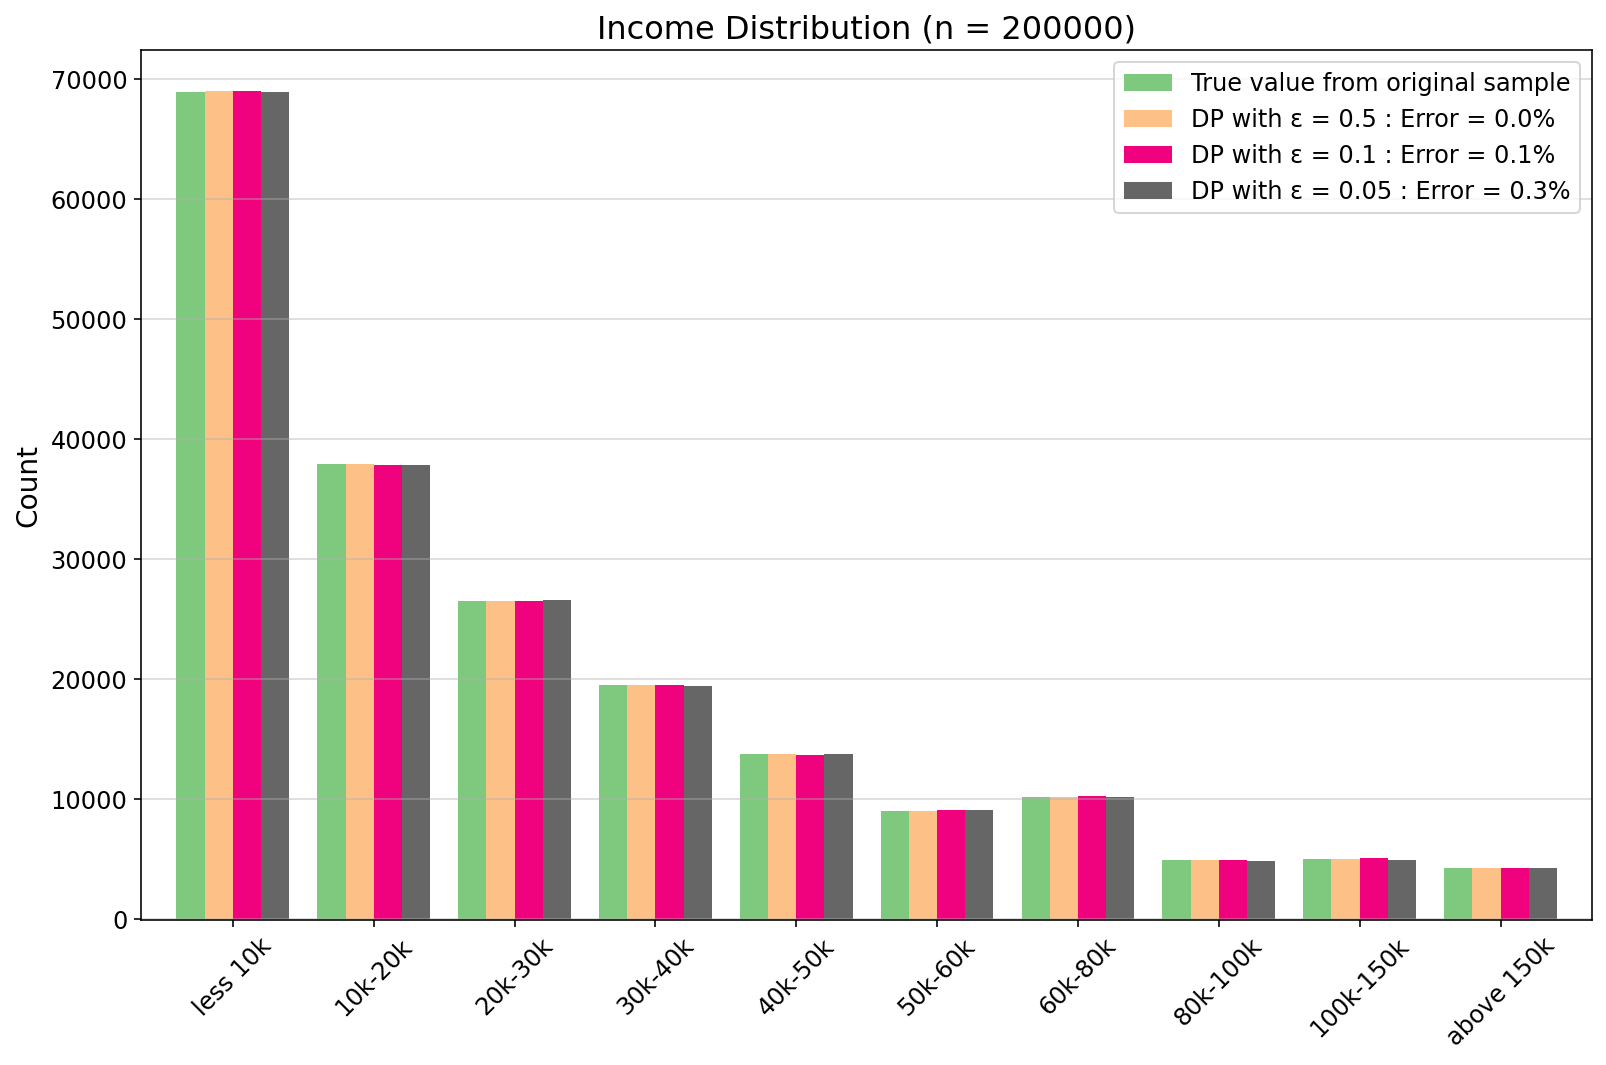

In [11]:
sample_sizes = [10000, 50000, 200000]
epsilons = [0.5, 0.1, 0.05]

for sample_size in sample_sizes:
    # draw sample 
    sample = df.sample(n = sample_size, random_state=0)
    # save sample for DP analysis
    sample.to_csv(samplefile, index=False)

    results = pd.DataFrame(index=income_categories)
    private_df = pd.read_csv(samplefile)
    results['True'] = private_df['inc_cat'].value_counts()

    labels = ['True value from original sample']
    
    for epsilon in epsilons:
        geo_counts, laplace_counts = dp_histo(epsilon)

        results['Geom-DP-'+str(epsilon)] = geo_counts[:len(income_categories)]
               
        error = perc_error(results['True'], results['Geom-DP-'+str(epsilon)])
            
        labels.append('DP with ε = ' + str(epsilon) + ' : Error = ' + str(round(error,1)) + '%')

    ax = results.plot.bar(rot=45, figsize=(13, 8), width=0.8, fontsize=12, colormap = 'Accent')
    plt.title('Income Distribution (n = '+str(sample_size)+')', fontsize=16)
    plt.legend(fontsize = 12, labels=labels)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel('Count', fontsize = 14)
    plt.ylim(-50)
    plt.show()